In [213]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import time

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

PATH = '../gesture_dataset_sample'

## helper function to load and parse annotations

In [214]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [215]:
# pretty-print first element
print(json.dumps(annotations['like']['0a245bef-2894-4b80-93bb-15fc26dc5ffb'], indent=2))

{
  "bboxes": [
    [
      0.36014919,
      0.77555186,
      0.03375774,
      0.06189803
    ],
    [
      0.46752245,
      0.47008987,
      0.0433003,
      0.07942283
    ]
  ],
  "labels": [
    "no_gesture",
    "like"
  ],
  "landmarks": [
    [],
    [
      [
        0.501357363816233,
        0.5250908121638677
      ],
      [
        0.4977713122223854,
        0.5111957865046843
      ],
      [
        0.49124377771947325,
        0.4984946239624881
      ],
      [
        0.487178186823625,
        0.4886811121991978
      ],
      [
        0.48552113062771846,
        0.4804272631972185
      ],
      [
        0.4807027409559707,
        0.5040614544395914
      ],
      [
        0.47330661017413767,
        0.5115544465603905
      ],
      [
        0.47689492969143144,
        0.5140015344255021
      ],
      [
        0.4810105759118617,
        0.5129608964487755
      ],
      [
        0.47995315315484915,
        0.5134275581164951
      ],
      [
   

## helper function to pre-process images (color channel conversion and resizing)

In [216]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [217]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

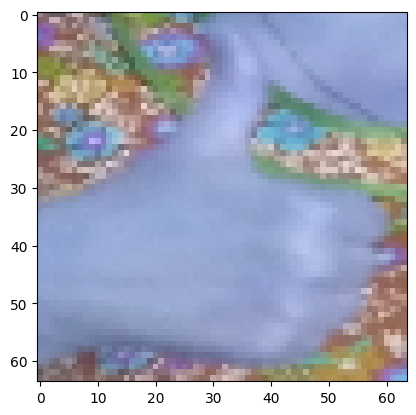

In [218]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [220]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


In [221]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu' # LeakyReLU
layer_count = 2
num_neurons = 512

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## now, we can train the model using the fit() function
## this will take a while

In [222]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4063 - loss: 1.0705 - val_accuracy: 0.4375 - val_loss: 1.0423 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5829 - loss: 0.9120 - val_accuracy: 0.7031 - val_loss: 0.7002 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7044 - loss: 0.6950 - val_accuracy: 0.7891 - val_loss: 0.5894 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7858 - loss: 0.5255 - val_accuracy: 0.7344 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8380 - loss: 0.4052 - val_accuracy: 0.8516 - val_loss: 0.4341 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8537 - loss: 0.3841 - val_accuracy: 0.8750 - val_loss: 0.3744 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8919 - loss: 0.2817 - val_acc

In [223]:
# let's have a look at our model
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_10 (RandomFlip)     │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_10              │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (8, 64, 64, 64)        │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (8, 16, 16, 32)        │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (8, 6, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (8, 6, 6, 32)          │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (8, 288)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (8, 512)               │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (8, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (8, 3)                 │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,464,779 (5.59 MB)

 Trainable params: 488,259 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 976,520 (3.73 MB)

## Plot accuracy and loss of the training process

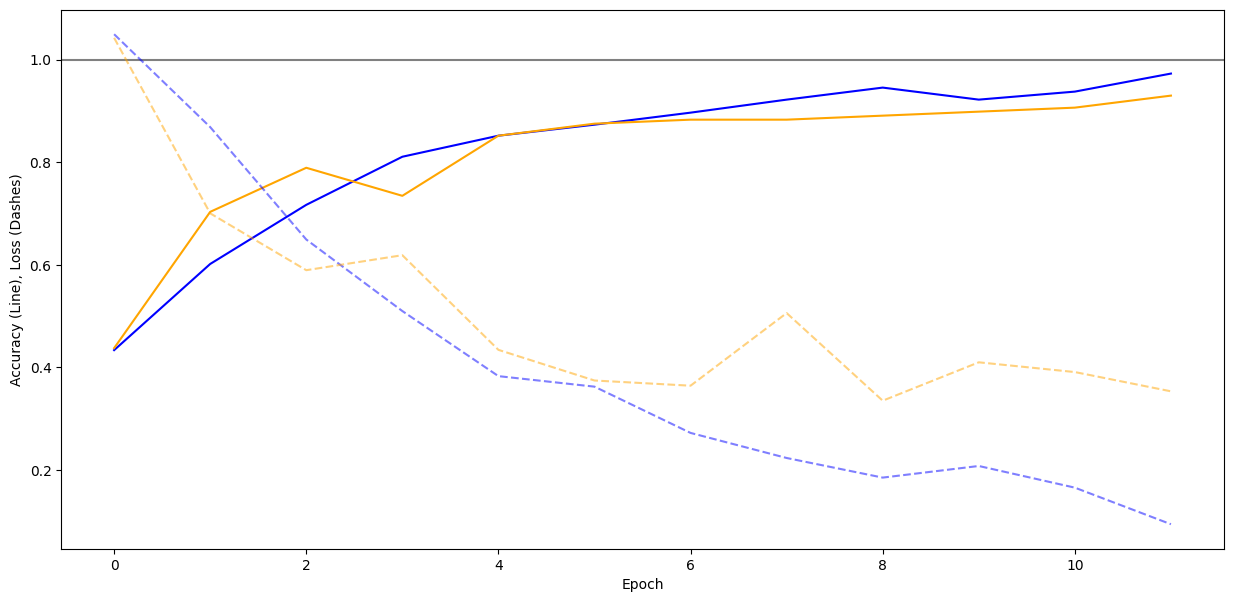

In [224]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [225]:
model.save('gesture_recognition.keras')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
before [[2.09975951e-07 9.99999404e-01 3.32121402e-07]
 [9.99999881e-01 1.02080918e-07 2.65098898e-09]
 [1.00000000e+00 5.55241577e-08 3.07495363e-10]
 [1.09033714e-07 9.99999881e-01 1.59492863e-08]
 [8.80909624e-07 9.99998569e-01 5.89989497e-07]
 [9.97317553e-01 2.21220986e-03 4.70280444e-04]
 [9.99184906e-01 2.85745249e-04 5.29285520e-04]
 [9.85538840e-01 1.43769830e-02 8.41092042e-05]
 [9.97905016e-01 1.73738634e-03 3.57628742e-04]
 [6.62031258e-03 9.92457151e-01 9.22602601e-04]
 [2.45883781e-02 1.56825352e-02 9.59729135e-01]
 [1.00000000e+00 4.19374260e-08 9.43103595e-10]
 [7.03204994e-10 1.00000000e+00 1.09509646e-09]
 [7.04655904e-05 9.69006479e-01 3.09229624e-02]
 [8.84590924e-01 1.14016645e-01 1.39237230e-03]
 [4.75494675e-02 3.19928713e-02 9.20457721e-01]
 [1.95606612e-03 3.01945198e-04 9.97742057e-01]
 [1.79988841e-04 1.39419382e-04 9.99680638e-01]
 [1.00000000e+00 1.30688449e-09 1.15904009e-12]
 [2.41224635e-02 7.19720311e-03 9.68680322e

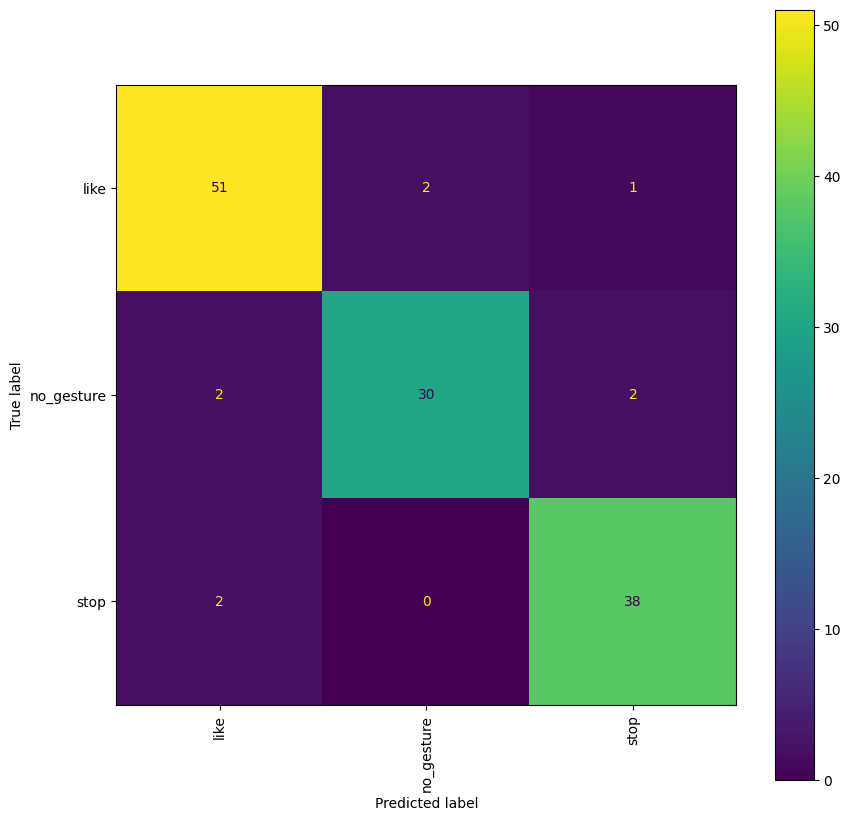

In [226]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

## Confusion Matrix Michael

In [227]:
annotations_mich = dict()

with open(f'annot-michael.json') as f:
    annotations_mich = json.load(f)

In [228]:
images_mich = []  # stores actual image data
labels_mich = []  # stores labels (as integer - because this is what our network needs)
label_names_mich = []  # maps label ints to their actual categories so we can understand predictions later

for filename in tqdm(os.listdir("pictures")):
    # extract unique ID from file name
    UID = filename.split('.')[0]
    img = cv2.imread(f'pictures/{filename}')
    
    # get annotation from the dict we loaded earlier
    try:
        annotation = annotations_mich[UID]
    except Exception as e:
        print(e)
        continue
    
    # iterate over all hands annotated in the image
    for i, bbox in enumerate(annotation['bboxes']):
        # annotated bounding boxes are in the range from 0 to 1
        # therefore we have to scale them to the image size
        x1 = int(bbox[0] * img.shape[1])
        y1 = int(bbox[1] * img.shape[0])
        w = int(bbox[2] * img.shape[1])
        h = int(bbox[3] * img.shape[0])
        x2 = x1 + w
        y2 = y1 + h
        
        # crop image to the bounding box and apply pre-processing
        crop = img[y1:y2, x1:x2]
        preprocessed = preprocess_image(crop)
        
        # get the annotated hand's label
        # if we have not seen this label yet, add it to the list of labels
        label = annotation['labels'][i]
        if label not in label_names_mich:
            label_names_mich.append(label)
        
        label_index = label_names_mich.index(label)
        
        # Convert NumPy arrays to lists before appending
        images_mich.append(preprocessed.tolist())
        labels_mich.append(label_index)


  0%|          | 0/15 [00:00<?, ?it/s]

In [229]:
X_test_mich = np.array(images_mich).astype('float32')
X_test_mich = X_test_mich / 255.

y_test_one_hot_mich = to_categorical(labels_mich)

test_label_mich = y_test_one_hot_mich

X_test_mich = X_test_mich.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

y_test_mich = labels_mich

#only two cause its only test data
print(X_test_mich.shape, test_label_mich.shape)

(15, 64, 64, 3) (15, 5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
before [[1.8589695e-05 9.9997920e-01 2.3109683e-06]
 [9.5831895e-01 1.8410869e-02 2.3270234e-02]
 [1.6507322e-02 9.8155802e-01 1.9346758e-03]
 [9.1465610e-01 2.6976396e-03 8.2646325e-02]
 [7.2353929e-01 1.0842658e-01 1.6803403e-01]
 [3.7686676e-01 5.9776860e-01 2.5364658e-02]
 [9.9999917e-01 8.8696612e-07 4.5858248e-10]
 [9.9999678e-01 3.2069456e-06 4.1044103e-08]
 [6.3672000e-05 4.4279408e-02 9.5565683e-01]
 [1.5812282e-02 9.8152143e-01 2.6662978e-03]
 [1.4227970e-08 1.0000000e+00 1.7146471e-08]
 [2.7259703e-12 1.0000000e+00 8.8230638e-13]
 [3.1825117e-08 9.9999809e-01 1.9512333e-06]
 [3.9752117e-06 9.9997878e-01 1.7310565e-05]
 [1.7798549e-03 2.8633133e-03 9.9535686e-01]]
probabilities [1 0 1 0 0 1 0 0 2 1 1 1 1 1 2]


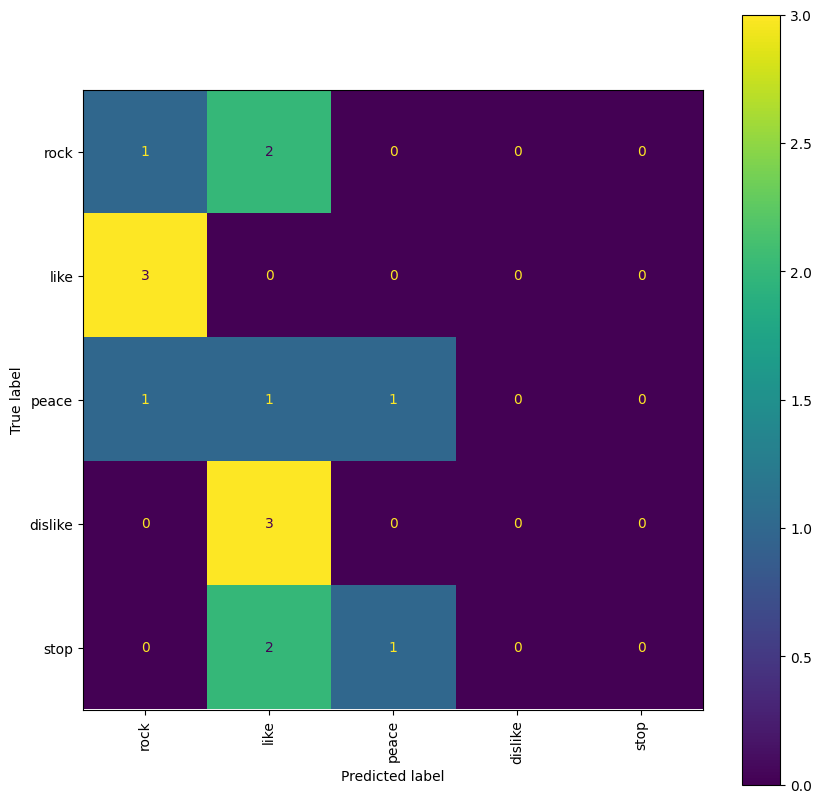

In [243]:
# Make predictions for our test data
y_predictions_mich = model.predict(X_test_mich)

# Print the raw probabilities
print('before', y_predictions_mich)

# Convert probabilities to classifications by taking the argmax
y_predictions_mich = np.argmax(y_predictions_mich, axis=1)

# Print the converted predictions
print('probabilities', y_predictions_mich)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_mich, y_predictions_mich)

# Plot the confusion matrix
fig = plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(conf_matrix, display_labels=label_names_mich).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')

plt.savefig('confusion_matrix_michael.png', format='png')

pass

## let's test our model in action

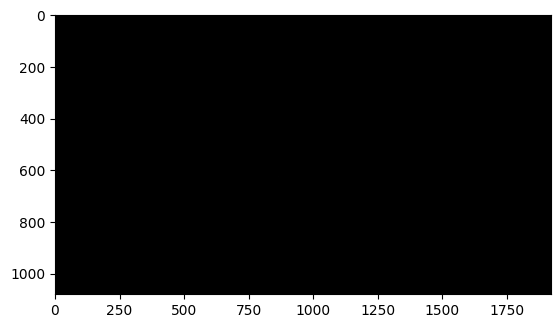

In [231]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if COLOR_CHANNELS == 1:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
cap.release()
plt.imshow(frame)

## manual cropping for demonstration purposes - you can do better!

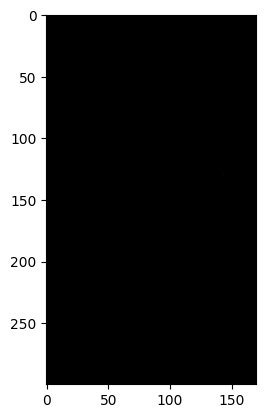

In [232]:
cropped = frame[80:380, 240:410]
plt.imshow(cropped)

(64, 64, 3)

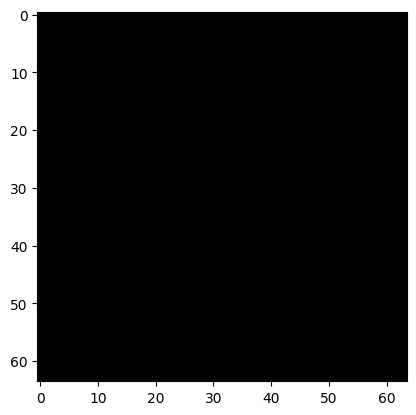

In [233]:
resized = cv2.resize(cropped, SIZE)#[20:350, 200:420], SIZE)
plt.imshow(resized)
resized.shape

In [234]:
reshaped = resized.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
reshaped.shape
prediction = model.predict(reshaped)

print(label_names[np.argmax(prediction)], np.max(prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
stop 0.9775823


(9, 9, 3, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

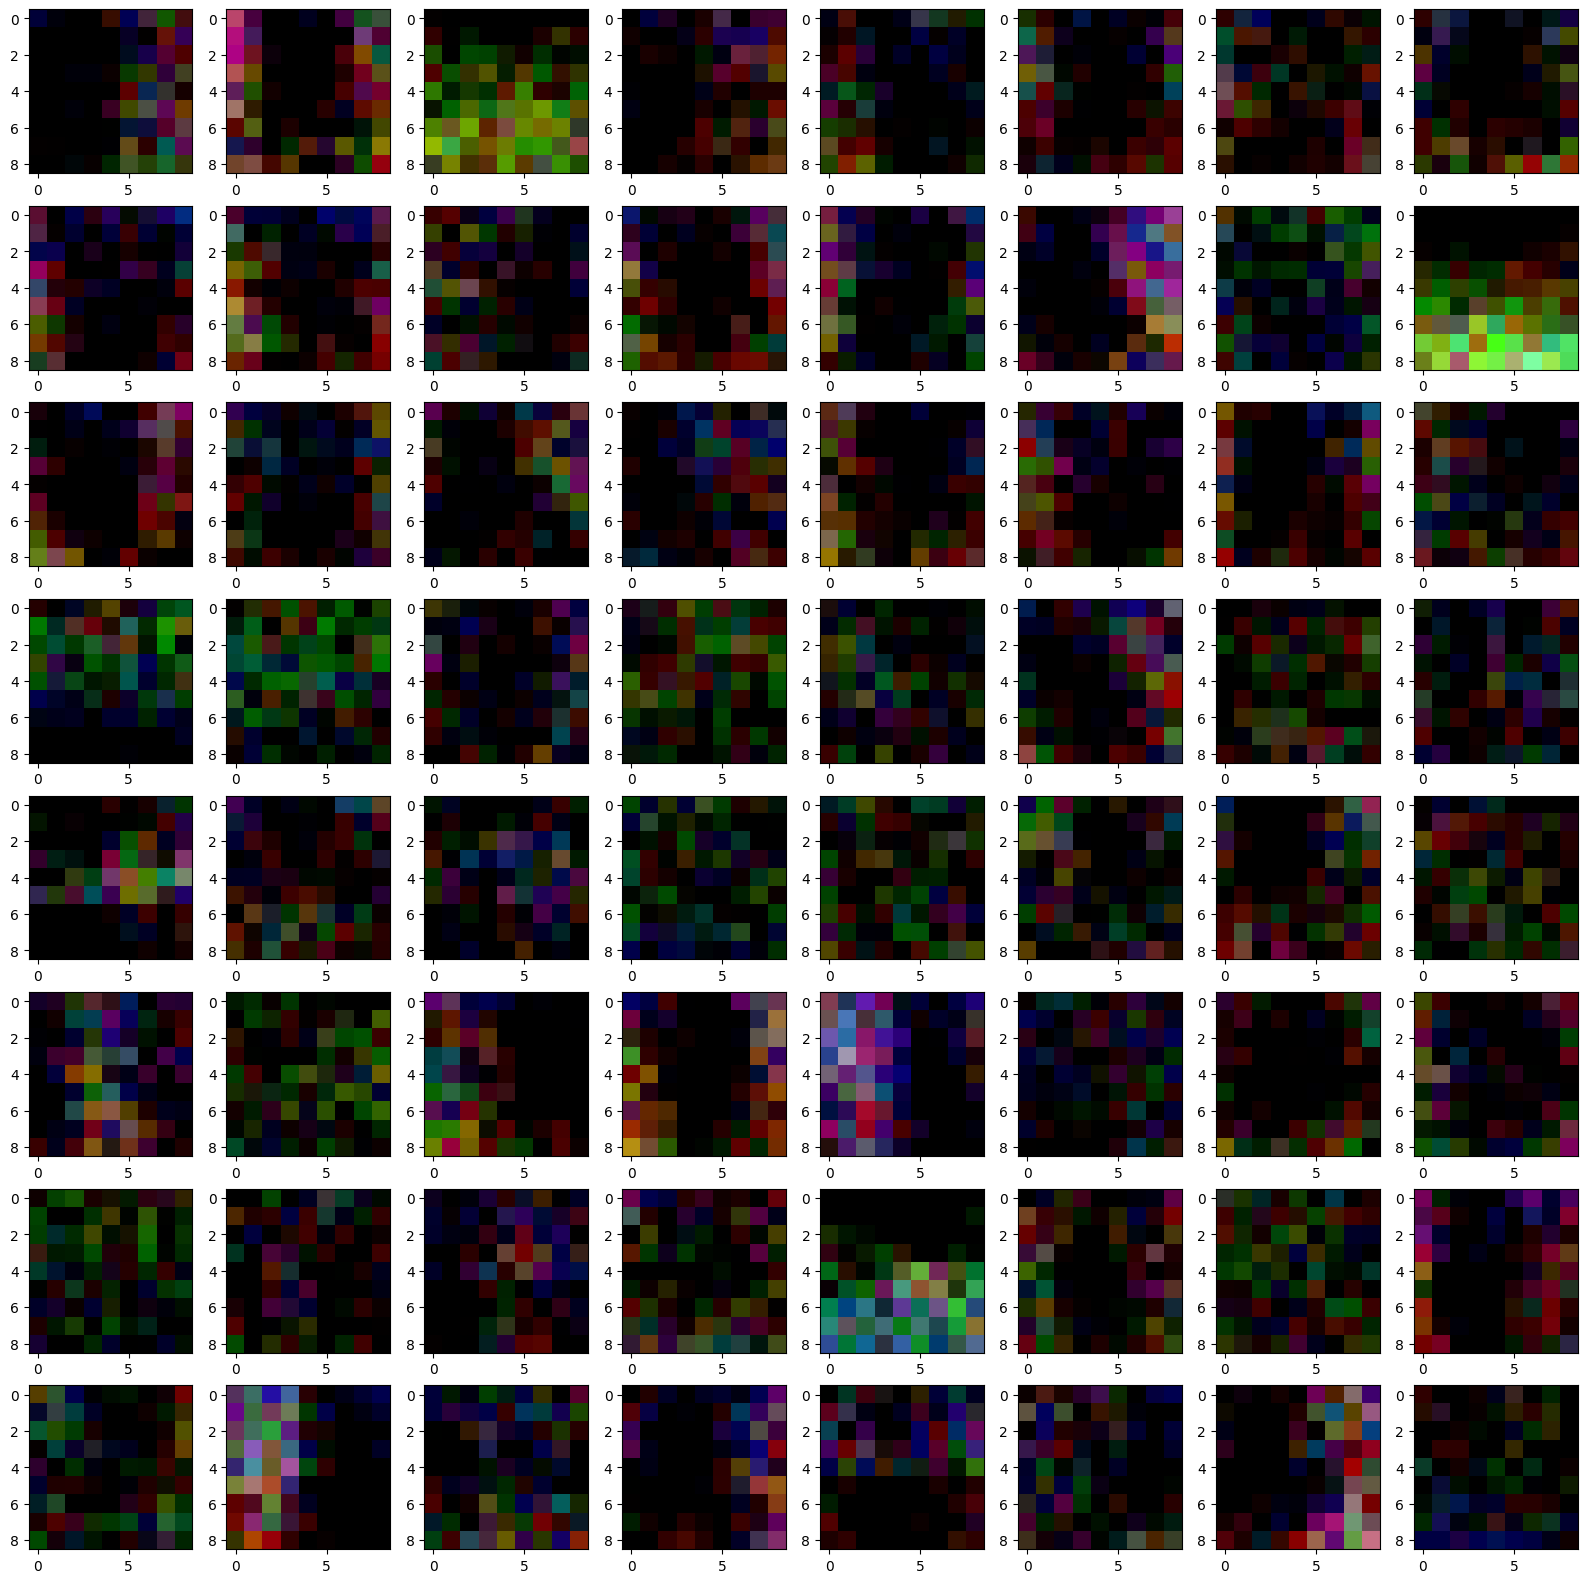

In [235]:
filters, biases = model.layers[2].get_weights()
print(filters.shape)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        img = filters[:,:,:,i*8+j] * (1 / np.max(filters))
        axes[i][j].imshow(img)

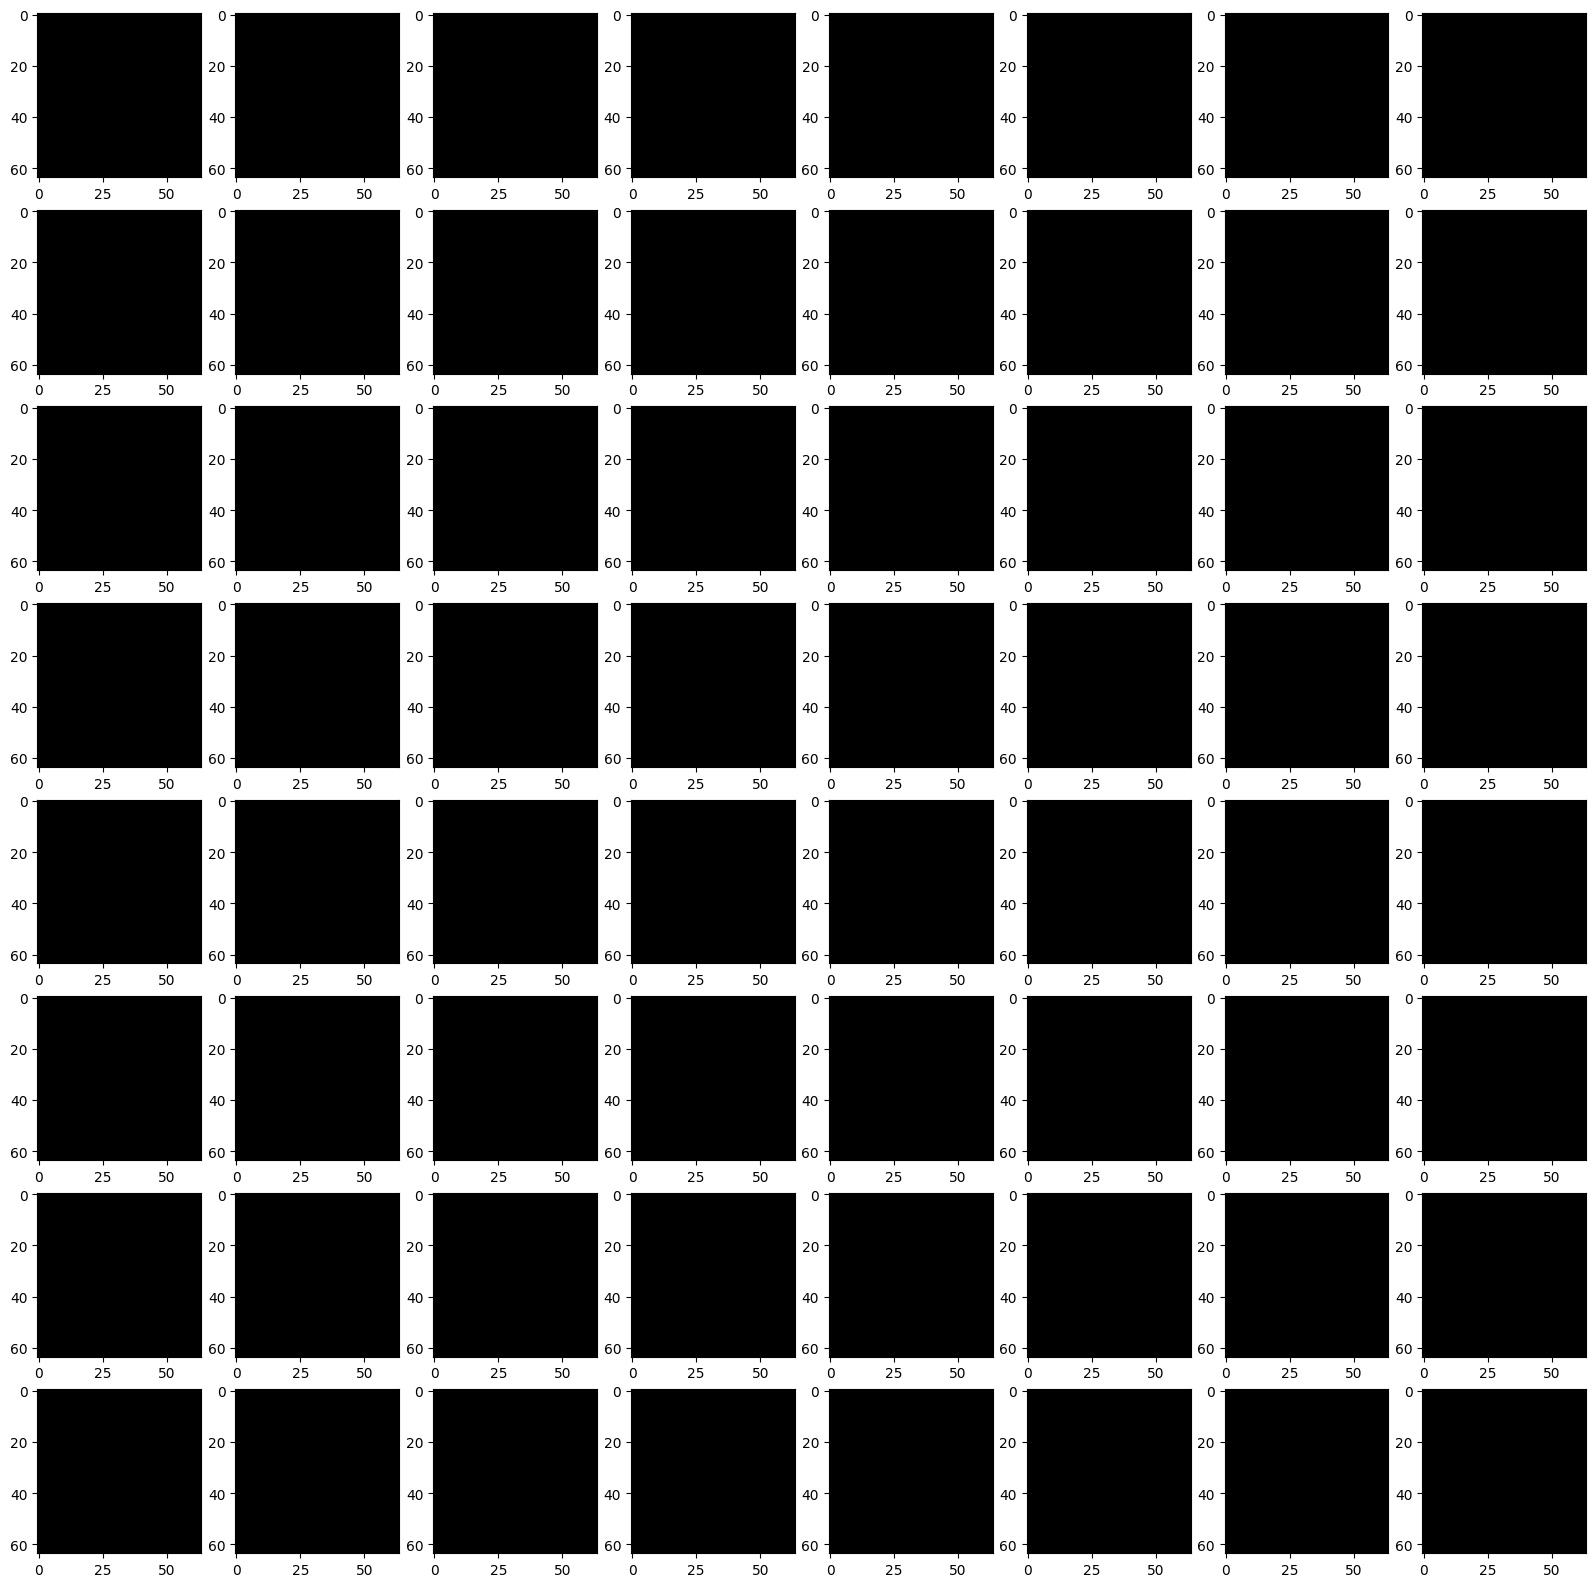

In [236]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        #axes[i][j].imshow(filters[:,:,:,i*8+j] * 255, 'gray')
        kernel = filters[:,:,0,i*8+j]

        #print(kernel.shape)

        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        filtered = cv2.filter2D(gray, -1, kernel)

        axes[i][j].imshow(filtered, 'gray')

## Transfer Learning

let's use a pre-trained model (VGG16) for our prediction

note that VGG16 needs three color channels

In [237]:
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 256

# load a VGG16 model trained on the imagenet dataset
# include_top=False -> do not include the output layer
# input_tensor -> tells the model about the dimensions of our images (VGG16 needs three color channels)
# pooling -> which type of pooling to use between convolutions; max or avg seem to be the best
VGG = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)), pooling='max')

# we want to use the VGG's original weights -> make those layers untrainable
for layer in VGG.layers:
    layer.trainable = False

# build a new model and add the VGG layers
model_vgg = Sequential()
model_vgg.add(VGG)

# append dense layers at the end
for i in range(layer_count - 1):
    model_vgg.add(Dense(num_neurons, activation=activation))
model_vgg.add(Dropout(0.2))

model_vgg.add(Dense(num_neurons, activation=activation))

# classifier
model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)

In [ ]:
history_vgg = model_vgg.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

In [ ]:
model_vgg.summary()

In [ ]:
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

In [ ]:
# let the model make predictions for our training data
y_predictions = model_vgg.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass